# Using The Statistic

In [238]:
# Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

stat_df = pd.read_csv('new csv files/stat_df.csv')
maps = pd.read_csv('original csv files/match_map_stats_000000000000.csv')

maps = maps.rename(columns={"match_winner": "match_winner_team", "map_winner": "map_winner_team"})

In [240]:
stat_df = pd.merge(stat_df, maps, on=['match_id', 'map_name'])
stat_df = stat_df.drop_duplicates(subset=['match_id', 'map_name', 'player', 'Eliminations'])

vals = stat_df.stage.unique().tolist()
playoffs = []
for i in vals:
    valid = ['Title', 'Playoffs', 'Championship', 'Postseason', 'Summer', 'Countdown', 'May', 'June']
    for j in valid:
        if j in i and not('Knockouts' in i or 'Qualifiers' in i):
            playoffs.append(i)

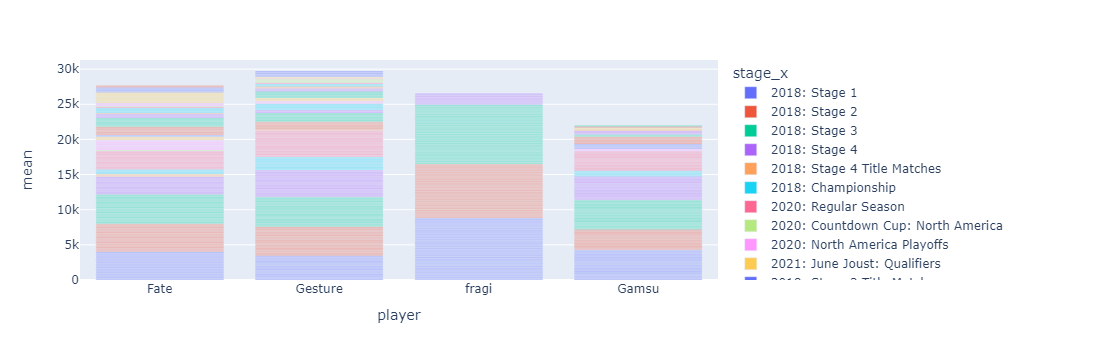

,match_id,map_name,map_type,team,player,Eliminations,Deaths,Assists,Objective Time,Time Building Ultimate,Damage Taken,Hero Damage Done,Barrier Damage Done,Shots Fired,Weapon Accuracy,Ultimates Used,Time Elapsed per Ultimate Earned,Stat,match_winner,map_winner,hero_Ana,hero_Ashe,hero_Baptiste,hero_Bastion,hero_Brigitte,hero_D.Va,hero_Doomfist,hero_Echo,hero_Genji,hero_Hanzo,hero_Junkrat,hero_Lúcio,hero_McCree,hero_Mei,hero_Mercy,hero_Moira,hero_Orisa,hero_Pharah,hero_Reaper,hero_Reinhardt,hero_Roadhog,hero_Sigma,hero_Soldier: 76,hero_Sombra,hero_Symmetra,hero_Torbjörn,hero_Tracer,hero_Widowmaker,hero_Winston,hero_Wrecking Ball,hero_Zarya,hero_Zenyatta,round_start_time,round_end_time,stage_x,game_number,match_winner_team,map_winner_team,map_loser,map_round,winning_team_final_map_score,losing_team_final_map_score,control_round_name,Attacker,Defender,team_one_name,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,stage_y,count,mean
3,10223,Dorado,PAYLOAD,Los Angeles Valiant,Fate,23.674787,8.609013,16.500609,55.572615,643.772019,12797.300699,6391.757292,1066.567565,0.0,0.0,5.0,74.577728,106.549841,True,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,01/11/18 00:12,01/11/18 00:20,2018: Stage 1,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,1,3,3,NaN,San Francisco Shock,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,75.615050,0.0,0.000000,240.0,NaN,NaN,2,0,2018: Stage 3,41.0,101.544050
25,10223,Ilios,CONTROL,Los Angeles Valiant,Fate,21.510735,6.618688,14.064711,72.455603,625.604018,11850.998731,7897.068292,1050.306562,0.0,0.0,5.0,75.096911,106.363319,True,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,01/11/18 01:11,01/11/18 01:16,2018: Stage 1,3,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,1,2,2,Lighthouse,Los Angeles Valiant,San Francisco Shock,Los Angeles Valiant,San Francisco Shock,0.000000,0.0,0.000000,0.0,99.0,100.0,0,1,2018: Stage 3,41.0,101.544050
47,10223,Temple of Anubis,ASSAULT,Los Angeles Valiant,Fate,36.741263,5.981136,26.487887,135.305251,568.369017,11114.304250,8029.199792,1316.054902,0.0,0.0,5.0,74.013857,126.099345,True,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,01/11/18 00:34,01/11/18 00:38,2018: Stage 1,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,1,4,4,NaN,San Francisco Shock,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,0.000000,0.0,250.492000,240.0,NaN,NaN,2,0,2018: Stage 3,41.0,101.544050
69,10229,Horizon Lunar Colony,ASSAULT,Los Angeles Valiant,Fate,25.053530,7.368685,20.141073,63.069558,940.398028,10042.951597,6868.284334,1579.064721,0.0,0.0,5.0,46.694562,112.026860,True,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,01/13/18 00:52,01/13/18 00:53,2018: Stage 1,2,Los Angeles Valiant,draw,draw,1,5,5,NaN,Los Angeles Valiant,Dallas Fuel,Dallas Fuel,Los Angeles Valiant,0.000000,0.0,373.930000,240.0,NaN,NaN,2,0,2018: Stage 3,41.0,101.544050
91,10229,Ilios,CONTROL,Los Angeles Valiant,Fate,28.524361,4.960758,14.882275,62.548965,299.836009,11536.396055,8456.580211,994.879413,0.0,0.0,3.0,98.168440,115.911250,True,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,01/13/18 01:40,01/13/18 01:43,2018: Stage 1,3,Los Angeles Valiant,Los Angeles Valiant,Dallas Fuel,1,2,2,Lighthouse,Los Angeles Valiant,Dallas Fuel,Los Angeles Valiant,Dallas Fuel,0.000000,0.0,0.000000,0.0,100.0,0.0,1,0,2018: Stage 3,41.0,101.544050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19204,34719,Route 66,PAYLOAD,Dallas Fuel,Gamsu,18.925187,5.40719

In [189]:
import plotly.express as px

winston_summary = stat_df[stat_df['hero_Winston'] == 1].groupby(['stage', 'player'])['Stat'].describe()[['count', 'mean']].reset_index()
#winston = winston[winston['count'] > 0].sort_values(by='mean')
winston = stat_df[(stat_df['hero_Winston'] == 1)]
winston = pd.merge(winston, winston_summary, on='player')
winston = winston[winston['count'] > 40]

fig = px.bar(winston, x=winston.player, y=winston['mean'], color=winston['stage_x'])
fig.show()
winston

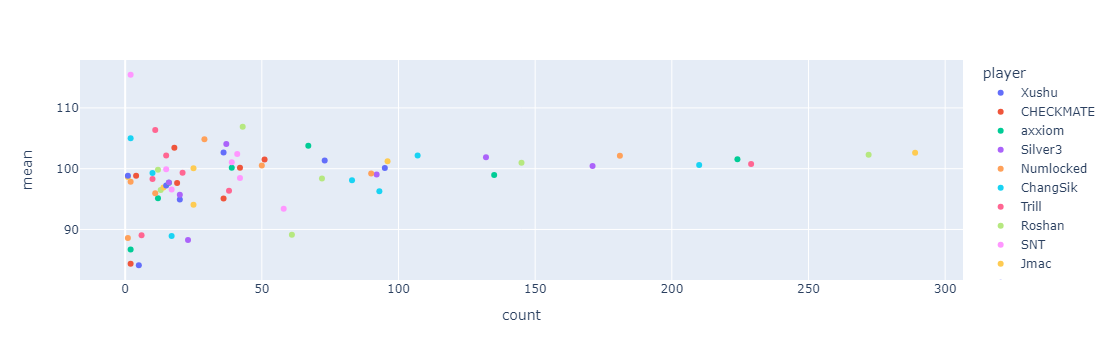

In [159]:
fig2 = px.scatter(winston, x=winston['count'], y=winston['mean'], color=winston['player'])
fig2.show()

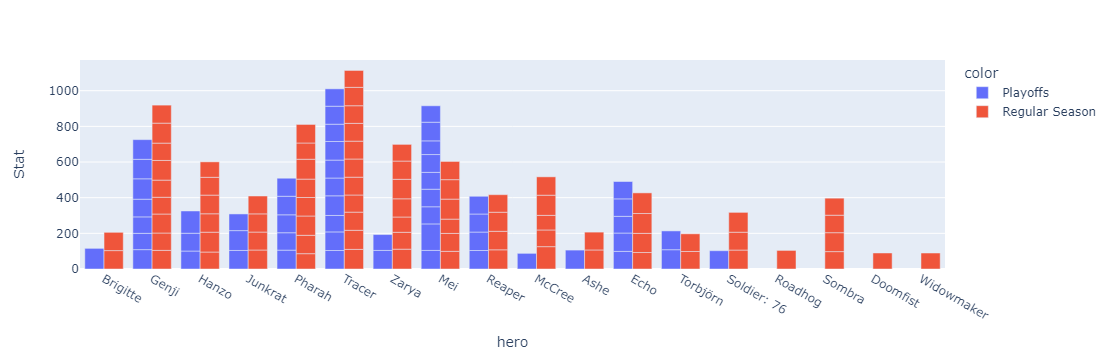

In [223]:
import plotly.express as px
#.groupby('match_id')['Stat'].mean().reset_index()

profit = stat_df
profit = profit[profit['player'] == 'Profit']
profit = profit.groupby(['stage', 'hero'])['Stat'].mean().reset_index()
color=np.array(['Regular Season']*profit.Stat.shape[0])
for i in playoffs:
    color[profit.stage==i] = 'Playoffs'

fig = px.bar(profit, x=profit.hero, y=profit.Stat, color=color, barmode='group')
fig.show()

In [272]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

app = Dash(__name__)
cur = pd.DataFrame()

app.layout = html.Div([
    html.H4('Average Stat by Player, Hero, and Stage'),
    dcc.Dropdown(
        id="dropdown",
        options=stat_df.player.unique(),
        clearable=False,
    ),
    dcc.Dropdown(
        id="dropdown2",
        clearable=False,
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("dropdown2", "options"),
    Input("dropdown", "value"))

def set_hero_options(player):
    cur = stat_df[stat_df['player'] == player]
    vals = ['All']
    vals.extend(cur.hero.unique())
    return vals

@app.callback(
    Output("dropdown2", "value"),
    Input("dropdown2", "options"))

def set_hero_value(heroes):
    return 'All'


@app.callback(
    Output("graph", "figure"),
    Input("dropdown", "value"),
    Input("dropdown2", "value"))


def update_bar_chart(player, hero):
    cur = stat_df[stat_df['player'] == player]
    if hero != 'All':
        cur = cur[cur['hero'] == hero] 
    cur = cur.groupby(['stage'])['Stat'].mean().reset_index()
    fig = px.bar(cur, x="stage", y="Stat", barmode='group')
    return fig


app.run_server(debug=True)